In [1]:
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import auc_score, recall_at_k
import pandas as pd
import numpy as np

c:\Users\TeYang\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
PATH = '../../data/'
SEED = 2022

## Create LightFM Dataset -- Leave One Last
https://towardsdatascience.com/how-i-would-explain-building-lightfm-hybrid-recommenders-to-a-5-year-old-b6ee18571309

In [3]:
train = pd.read_csv(PATH + 'processed/' + 'train_lol.csv')[['userid', 'shop', 'rating']]
val = pd.read_csv(PATH + 'processed/' + 'val_lol.csv')[['userid', 'shop', 'rating']]
test = pd.read_csv(PATH + 'processed/' + 'test_lol.csv')[['userid', 'shop', 'rating']]

shop_features = pd.read_csv(PATH + 'processed/' + 'coffee_shops_context_ohe.csv')

In [4]:
# get list of shop features
sf = []
features = list(shop_features.columns.drop('alias'))
for v in range(2):
    for f in features:
        sf.append(f + ':' + str(v))

sorted(sf)[:10]

['Central:0',
 'Central:1',
 'Northeast:0',
 'Northeast:1',
 'Northwest:0',
 'Northwest:1',
 'Southeast:0',
 'Southeast:1',
 'Southwest:0',
 'Southwest:1']

In [229]:
train_dataset = Dataset()
train_dataset.fit(
    list(train['userid'].unique()),           # train has all users
    list(shop_features['alias'].unique()),    # train does not have all shops
    item_features= sf
)

In [230]:
# user-item interaction matrix
(interactions, weights) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in train.values])
(interactions_val, weights_val) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in val.values])
(interactions_test, weights_test) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in test.values])

In [231]:
# shop feature matrix
sf_tuple = []
for shop_idx,row in enumerate(shop_features.drop('alias',axis=1).values):
    sf_tuple.append((shop_features['alias'][shop_idx], [features[i] + ':' + str(col) for i,col in enumerate(row)]))
print(sf_tuple[0])

sf_mat = train_dataset.build_item_features(sf_tuple, normalize= False)

('nylon-coffee-roasters-singapore', ['price_1:1', 'price_2:0', 'price_3:0', 'price_4:0', 'bakeries:0', 'bars:0', 'breakfast_brunch:0', 'cafes:0', 'coffeeroasteries:1', 'desserts:0', 'icecream:0', 'juicebars:0', 'sandwiches:0', 'themedcafes:0', 'Central:1', 'Northeast:0', 'Northwest:0', 'Southeast:0', 'Southwest:0'])


In [232]:
user_id_map, user_feature_map, item_id_map, item_feature_map = train_dataset.mapping()

In [233]:
results = {}

for epoch in range(0,55,5):
      model = LightFM(loss='warp', random_state=SEED,)
      model.fit(
            interactions,
            item_features= sf_mat,
            sample_weight= weights,
            epochs=epoch,
            num_threads=4,
      )
      train_score = recall_at_k(
            model,
            interactions,
            item_features= sf_mat,
            k=5
      ).mean()

      val_score = recall_at_k(
            model,
            interactions_val,
            item_features= sf_mat,
            k=5
      ).mean()

      results[epoch] = (train_score, val_score)

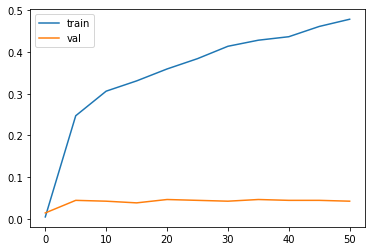

In [234]:
import matplotlib.pyplot as plt
plt.plot(*zip(*results.items()))
plt.legend(['train','val'])
plt.show()

In [242]:
model = LightFM(loss='warp', random_state=SEED)
model.fit(
    interactions,
    item_features= sf_mat,
    sample_weight= weights,
    epochs=5,
    num_threads=4
)

recall_at_k(
    model,
    interactions_test,
    item_features= sf_mat,
    k=5
).mean()

0.03621730382293763

In [245]:
len(train['userid'].unique())

497

In [278]:
preds = []
for user in train['userid'].unique():
    user_idx = user_id_map[user]
    n_users, n_items = interactions.shape 
    preds.append(model.predict(user_idx, np.arange(n_items)))

In [309]:
preds = np.array(preds)
preds_sort_idx = np.argsort(preds)
preds_sort_idx_20 = np.flip(preds_sort_idx[:,-20:], axis=1)
preds_sort_idx_20

array([[517,   0, 211, ..., 249, 255,  19],
       [ 64,   6, 517, ..., 866, 310, 628],
       [ 15, 517,   0, ...,  85, 489,  36],
       ...,
       [ 15,   0, 713, ..., 361,  85,  64],
       [256, 631,  85, ..., 258, 393, 905],
       [767, 275, 256, ..., 399, 905, 671]], dtype=int64)

In [336]:
idx_item_map = {v:k for k,v in item_feature_map.items()}
feature_embeddings = model.item_embeddings[interactions.shape[1]:]

In [419]:
top_cared_aspects=10

explanations = []
for i,user in enumerate(train['userid'].unique()):
    user_explanations = []
    for shop_idx in preds_sort_idx_20[i]:
        U = user
        S = shop_idx

        user2aspect_affinity = np.dot(feature_embeddings, model.user_embeddings[user_id_map[U]])
        user2aspect_affinity = np.argsort(user2aspect_affinity)[::-1][:top_cared_aspects]
        aspect_affinity_sorted = np.vectorize(idx_item_map.get)(user2aspect_affinity + interactions.shape[1])

        item2aspect_quality = np.dot(feature_embeddings, model.item_embeddings[S])
        item2aspect_quality = np.argsort(item2aspect_quality)[::-1]
        aspect_quality_sorted = np.vectorize(idx_item_map.get)(item2aspect_quality + interactions.shape[1])

        interested_aspect = aspect_quality_sorted[np.isin(aspect_quality_sorted, aspect_affinity_sorted)][0]
        user_explanations.append(interested_aspect)
    explanations.append(user_explanations)

In [422]:
explanations[300]

['Southeast:1',
 'coffeeroasteries:1',
 'coffeeroasteries:1',
 'Southeast:1',
 'coffeeroasteries:1',
 'coffeeroasteries:1',
 'coffeeroasteries:1',
 'bars:1',
 'coffeeroasteries:1',
 'Central:0',
 'bars:1',
 'bars:1',
 'coffeeroasteries:1',
 'coffeeroasteries:1',
 'bars:1',
 'Southeast:1',
 'coffeeroasteries:1',
 'coffeeroasteries:1',
 'coffeeroasteries:1',
 'coffeeroasteries:1']

In [339]:
shop_rec = np.vectorize(idx_item_map.get)(preds_sort_idx_20)
shop_rec

array([['maxwell-food-centre-singapore-3',
        'nylon-coffee-roasters-singapore',
        'laurent-bernard-chocolatier-singapore', ...,
        'the-muffinry-bakery-and-cafe-singapore',
        'the-bravery-cafe-singapore', 'sweetspot-singapore-2'],
       ['the-book-cafe-singapore',
        'common-man-coffee-roasters-singapore',
        'maxwell-food-centre-singapore-3', ..., 'sunday-folks-singapore',
        'jimmy-monkey-cafe-and-bar-singapore',
        'chinatown-complex-market-and-food-centre-singapore'],
       ['tiong-bahru-bakery-singapore-4',
        'maxwell-food-centre-singapore-3',
        'nylon-coffee-roasters-singapore', ..., 'd-good-cafe-singapore',
        'penny-university-singapore',
        'pacamara-boutique-coffee-roasters-singapore'],
       ...,
       ['tiong-bahru-bakery-singapore-4',
        'nylon-coffee-roasters-singapore', 'level33-singapore-4', ...,
        'food-for-thought-singapore', 'd-good-cafe-singapore',
        'the-book-cafe-singapore'],
   

In [437]:
user_recs = pd.DataFrame.from_dict(dict(zip(train['userid'].unique(), shop_rec)), orient='index')
user_rec_exps = pd.DataFrame.from_dict(dict(zip(train['userid'].unique(), explanations)), orient='index')
user_recs.to_csv('../../results/outputs/lightFM_LOL_recommendations.csv')
user_rec_exps.to_csv('../../results/outputs/lightFM_LOL_explanations.csv')

In [434]:
user_recs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-5YMIME_WEin_by41Bj-3Q,maxwell-food-centre-singapore-3,nylon-coffee-roasters-singapore,laurent-bernard-chocolatier-singapore,ps-cafe-singapore-8,the-book-cafe-singapore,the-lokal-singapore,tiong-bahru-bakery-singapore-4,common-man-coffee-roasters-singapore,strangers-reunion-singapore,curious-palette-singapore,paddy-hills-singapore,twg-tea-singapore-3,da-paolo-gastronomia-bukit-timah-bukit-timah,jones-the-grocer-singapore-3,percolate-singapore,ps-cafe-petit-singapore,the-fabulous-baker-boy-singapore,the-muffinry-bakery-and-cafe-singapore,the-bravery-cafe-singapore,sweetspot-singapore-2
-G1YjYxjDpxOBzFgo36ORA,the-book-cafe-singapore,common-man-coffee-roasters-singapore,maxwell-food-centre-singapore-3,tiong-bahru-bakery-singapore-4,level33-singapore-4,my-awesome-cafe-singapore,the-assembly-ground-singapore,boufe-boutique-cafe-singapore,curious-palette-singapore,laurent-bernard-chocolatier-singapore,ps-cafe-petit-singapore,privé-café-singapore,plain-vanilla-bakery-singapore-2,spize-singapore-2,ps-cafe-singapore-8,wellsmoocht-singapore-2,twg-tea-on-the-bay-singapore,sunday-folks-singapore,jimmy-monkey-cafe-and-bar-singapore,chinatown-complex-market-and-food-centre-singa...
-WShM_YFbtG4OcE0vrFVyw,tiong-bahru-bakery-singapore-4,maxwell-food-centre-singapore-3,nylon-coffee-roasters-singapore,level33-singapore-4,common-man-coffee-roasters-singapore,group-therapy-coffee-singapore,sarnies-singapore,strangers-reunion-singapore,the-book-cafe-singapore,carpenter-and-cook-singapore,ps-cafe-singapore-8,paul-singapore-3,fika-singapore,ps-cafe-petit-singapore,patisserie-g-singapore,tiong-bahru-bakery-singapore,two-blur-guys-singapore,d-good-cafe-singapore,penny-university-singapore,pacamara-boutique-coffee-roasters-singapore
-XaIf12ricWc5z5BRt9nnQ,the-book-cafe-singapore,level33-singapore-4,tiong-bahru-bakery-singapore-4,jimmy-monkey-cafe-and-bar-singapore,drury-lane-singapore,strangers-reunion-singapore,nylon-coffee-roasters-singapore,common-man-coffee-roasters-singapore,food-for-thought-singapore,sarnies-singapore,ps-cafe-singapore-8,maxwell-food-centre-singapore-3,penny-university-singapore,symmetry-singapore,two-blur-guys-singapore,group-therapy-coffee-singapore,paul-singapore-3,carpenter-and-cook-singapore,violet-oons-kitchen-singapore,d-good-cafe-singapore
-fUWq6sOIEe1uTUhNKS9sQ,tiong-bahru-bakery-singapore-4,the-assembly-ground-singapore,level33-singapore-4,common-man-coffee-roasters-singapore,my-awesome-cafe-singapore,spize-singapore-2,maxwell-food-centre-singapore-3,tiong-bahru-food-market-and-hawker-centre-sing...,carpenter-and-cook-singapore,ps-cafe-petit-singapore,nylon-coffee-roasters-singapore,group-therapy-coffee-singapore,brawn-and-brains-coffee-singapore,plain-vanilla-bakery-singapore-2,wellsmoocht-singapore-2,flor-patisserie-singapore,sweetspot-singapore-2,la-ristrettos-singapore,wheelers-yard-singapore,fika-singapore


In [435]:
user_rec_exps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-5YMIME_WEin_by41Bj-3Q,sandwiches:1,juicebars:1,price_2:0,sandwiches:1,sandwiches:1,price_4:1,juicebars:1,juicebars:1,Southwest:1,price_4:1,price_4:1,price_4:1,price_4:1,price_4:1,price_1:1,Northeast:0,juicebars:1,price_1:1,sandwiches:1,price_2:0
-G1YjYxjDpxOBzFgo36ORA,price_3:1,bars:1,bars:1,bars:1,bars:1,price_3:1,price_3:1,desserts:1,desserts:1,desserts:1,price_3:1,price_3:1,Central:1,cafes:1,price_3:1,cafes:1,bars:1,price_3:1,bars:1,Northwest:0
-WShM_YFbtG4OcE0vrFVyw,Southeast:1,Northwest:0,Central:0,Southeast:1,Southeast:1,price_2:1,Central:0,Central:0,cafes:1,Southeast:1,price_2:1,Central:0,desserts:0,cafes:1,Southeast:1,Central:0,Southeast:1,Central:0,Southeast:1,themedcafes:1
-XaIf12ricWc5z5BRt9nnQ,price_3:1,Southeast:1,coffeeroasteries:1,bars:1,bars:1,coffeeroasteries:1,coffeeroasteries:1,coffeeroasteries:1,bars:1,Central:0,price_3:1,coffeeroasteries:1,Southeast:1,coffeeroasteries:1,bars:1,coffeeroasteries:1,coffeeroasteries:1,coffeeroasteries:1,bars:1,coffeeroasteries:1
-fUWq6sOIEe1uTUhNKS9sQ,coffeeroasteries:1,bakeries:1,coffeeroasteries:1,coffeeroasteries:1,coffeeroasteries:1,coffeeroasteries:1,coffeeroasteries:1,bakeries:1,coffeeroasteries:1,bakeries:1,coffeeroasteries:1,bakeries:1,bakeries:1,coffeeroasteries:1,coffeeroasteries:1,bakeries:1,bakeries:1,bakeries:1,bakeries:1,bakeries:1


## Temporal Global Split

In [6]:
train = pd.read_csv(PATH + 'processed/' + 'train_tgs.csv')[['userid', 'shop', 'rating']]
val = pd.read_csv(PATH + 'processed/' + 'val_tgs.csv')[['userid', 'shop', 'rating']]
test = pd.read_csv(PATH + 'processed/' + 'test_tgs.csv')[['userid', 'shop', 'rating']]

shop_features = pd.read_csv(PATH + 'processed/' + 'coffee_shops_context.csv')

In [7]:
train_dataset = Dataset()
train_dataset.fit(
    list(train['userid'].unique()),           # train has all users
    list(shop_features['alias'].unique()),    # train does not have all shops
    item_features= sf
)

In [8]:
# user-item interaction matrix
(interactions, weights) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in train.values])
(interactions_val, weights_val) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in val.values])
(interactions_test, weights_test) = train_dataset.build_interactions([(x[0], x[1], x[2]) for x in test.values])

ValueError: User id eipO40vDyfHFXug2ElJ7Yg not in user id mapping. Make sure you call the fit method.